<a href="https://www.kaggle.com/code/mikedelong/eda-with-map?scriptVersionId=137048121" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
df = pd.read_csv(filepath_or_buffer='/kaggle/input/los-angeles-crime-dataset-2020-present/Crime_Data_from_2020_to_Present.csv', 
                 parse_dates=['Date Rptd', 'DATE OCC']).drop(columns=['DR_NO'])
df.sample(n=7)

,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,Mocodes,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
332240,2021-07-20,2021-07-20,1400,14,Pacific,1494,1,510,VEHICLE - STOLEN,0344 1300,...,IC,Invest Cont,510.0,NaN,NaN,NaN,100 WORLD WY,NaN,33.9455,-118.4006
248582,2021-11-19,2021-11-19,2330,2,Rampart,241,2,624,BATTERY - SIMPLE ASSAULT,1817 0416 0446 0913,...,AO,Adult Other,624.0,NaN,NaN,NaN,400 S LA FAYETTE PARK PL,NaN,34.0657,-118.2815
683927,2023-05-14,2023-05-14,1600,10,West Valley,1044,2,626,INTIMATE PARTNER - SIMPLE ASSAULT,2000 0416 0400 0913 1814 0329 0446,...,IC,Invest Cont,626.0,NaN,NaN,NaN,18400 HATTERAS ST,NaN,34.1775,-118.5337
523753,2022-06-06,2022-06-06,955,15,N Hollywood,1553,1,330,BURGLARY FROM VEHICLE,1300 0344,...,IC,Invest Cont,330.0,NaN,NaN,NaN,12000 KLING ST,NaN,34.1558,-118.3943
509783,2022-08-16,2022-08-16,1500,10,West Valley,1019,2,946,OTHER MISCELLANEOUS CRIME,NaN,...,IC,Invest Cont,946.0,NaN,NaN,NaN,7200 HASKELL AV,NaN,34.2013,-118.4749
19614,2020-05-22,2020-05-22,49,8,West LA,847,1,510,VEHICLE - STOLEN,NaN,...,IC,Invest Cont,510.0,NaN,NaN,NaN,2300 S BEVERLY GLEN BL,NaN,34.0485,-118.4190
407933,2021-10-08,2021-09-26,1945,7,Wilshire,747,1,341,"THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LI...",0344 0913,...,IC,Invest Cont,341.0,NaN,NaN,NaN,1100 S LONGWOOD AV,NaN,34.0546,-118.3394


In [2]:
df.columns

Index(['Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME', 'Rpt Dist No',
       'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes', 'Vict Age', 'Vict Sex',
       'Vict Descent', 'Premis Cd', 'Premis Desc', 'Weapon Used Cd',
       'Weapon Desc', 'Status', 'Status Desc', 'Crm Cd 1', 'Crm Cd 2',
       'Crm Cd 3', 'Crm Cd 4', 'LOCATION', 'Cross Street', 'LAT', 'LON'],
      dtype='object')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<Axes: xlabel='Vict Age', ylabel='Density'>

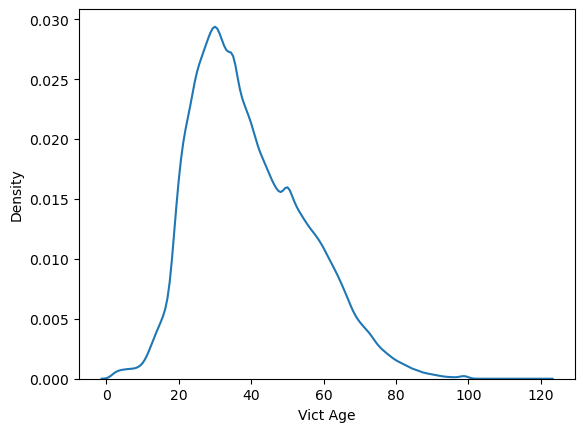

In [3]:
# let's look at some distributions
%matplotlib inline
from seaborn import kdeplot
# we need to drop ages = 0 to filter out unknowns
kdeplot(data=df[df['Vict Age'] > 0], x='Vict Age')

In [4]:
from folium import Map
from folium import Marker

sample_size = 1000
sample_df = df.sample(sample_size)

# for some reason we have to fudge the center a little
lon_fudge = -0.5
location_map = Map(location=[sample_df['LAT'].mean(), sample_df['LON'].mean() + lon_fudge], zoom_start=10)
for index, row in sample_df.iterrows():
    popup = '{}/{}/{}:{}'.format(row['LOCATION'], row['AREA NAME'], row['Crm Cd Desc'], row['Status'])
    Marker([row['LAT'], row['LON']], popup=popup).add_to(parent=location_map)

location_map

In [5]:
df.shape

(752911, 27)

In [6]:
df['Crm Cd'].nunique()

138

We have 138 codes; clearly we can't make sense of a pie with that many slices, so let's look at the top ten or so

In [7]:
crime_code_value_counts = df['Crm Cd Desc'].value_counts()
code_df = pd.DataFrame(data={'Code': crime_code_value_counts.index, 'Count': crime_code_value_counts.values}).reset_index(drop=True)
code_df.head(10)

,Code,Count
0,VEHICLE - STOLEN,80439
1,BATTERY - SIMPLE ASSAULT,59630
2,THEFT OF IDENTITY,48645
3,BURGLARY FROM VEHICLE,46526
4,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",46157
5,BURGLARY,45717
6,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",43149
7,THEFT PLAIN - PETTY ($950 & UNDER),38510
8,INTIMATE PARTNER - SIMPLE ASSAULT,37947
9,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),29310


In [8]:
import plotly.express as px
code_df.loc[code_df['Count'] < 15000, 'Code'] = 'Other' # we have too many codes so let's apply a threshold
px.pie(code_df, names='Code', values='Count').show()

In [9]:
# Surely the areas are shaped so the crime is roughly the same in each one; right?
area_value_counts = df['AREA NAME'].value_counts()
area_df = pd.DataFrame(data={'Area': area_value_counts.index, 'Count': area_value_counts.values}).reset_index(drop=True)
px.pie(area_df, names='Area', values='Count').show()

In [10]:
victim_descent = df['Vict Descent'].replace(to_replace={'B': 'Black', 'H': 'Hispanic', 'W': 'White',}).value_counts()
descent_df = pd.DataFrame(data={'Descent': victim_descent.index, 'Count': victim_descent.values}).reset_index(drop=True)
descent_df.loc[descent_df['Count'] < 80000, 'Descent'] = 'Other' # threshold
px.pie(descent_df, names='Descent', values='Count').show()

<Axes: xlabel='DATE OCC'>

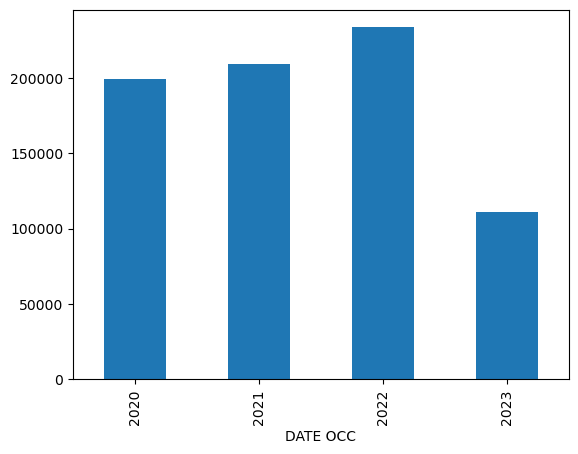

In [11]:
# not surprisingly we have an incomplete current year
df['DATE OCC'].groupby(df['DATE OCC'].dt.year).count().plot(kind='bar')

<Axes: xlabel='DATE OCC'>

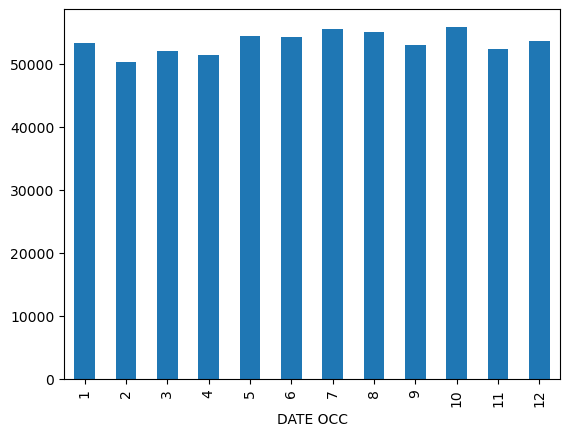

In [12]:
# where we have complete years we do not have obvious seasonality
df[df['DATE OCC'].dt.year < 2023]['DATE OCC'].groupby(df['DATE OCC'].dt.month).count().plot(kind='bar')

<Axes: xlabel='DATE OCC'>

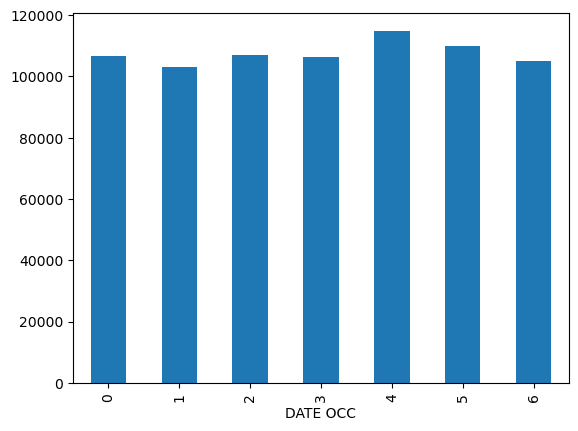

In [13]:
# nor do weekends seem to matter much
df['DATE OCC'].groupby(df['DATE OCC'].dt.dayofweek).count().plot(kind='bar')

<Axes: xlabel='DATE OCC', ylabel='Density'>

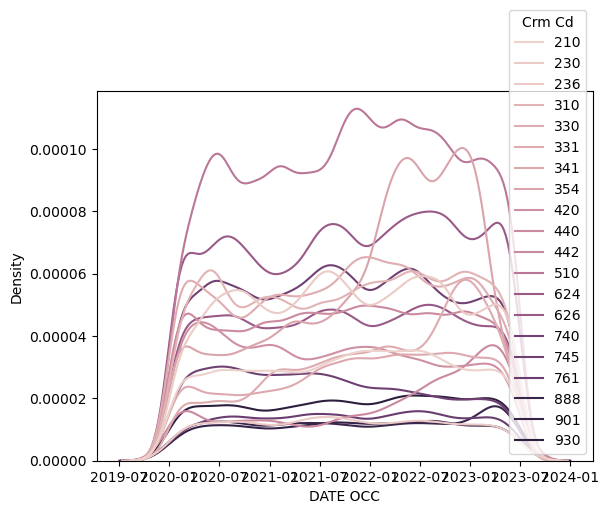

In [14]:
kdeplot(data=df[df['Crm Cd'].isin(df['Crm Cd'].value_counts()[:20].index.tolist())], x='DATE OCC', hue='Crm Cd')